In [1]:
import chess
import chess.engine
import os
import sys
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import chess.pgn

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

import utils.chess_utils as chess_utils
from utils.pikeBot_chess_utils import Pikebot, PikeBotModelWrapper

In [3]:
def get_maia_path(maia_elo):
    if maia_elo == 1100:
        return "D:/Program Files/MaiaChess/Maia1/lc0.exe"
    if maia_elo == 1500:
        return "D:/Program Files/MaiaChess/Maia5/lc0.exe"
    if maia_elo == 1900:
        return "D:/Program Files/MaiaChess/Maia9/lc0.exe"
    raise ValueError("Maia elo must be from (1100, 1500, 1900)")


In [4]:
maia_elo = 1100
maia_path = get_maia_path(maia_elo)
stockfish_path = "D:/Program Files/Stockfish/stockfish/stockfish-windows-x86-64-avx2.exe"
model_path = "../Models/PikeBot_Models/PikeBot.pth"
preprocessing_parameters_path = "../model_loading_data/preprocessing_parameters.json"
time_limit = 0.01

In [5]:
class MaiaChess(chess_utils.Player):
    def __init__(self, maia_path: str) -> None:
        super().__init__()
        #redirect error stderr not to display messages from the engine
        self.engine = chess.engine.SimpleEngine.popen_uci(maia_path, stderr=subprocess.DEVNULL)

    def get_best_move(self, board):
        result = self.engine.play(board, chess.engine.Limit(nodes=1))
        move = result.move
        return move

In [98]:
maiaChess = MaiaChess(maia_path)

In [7]:
model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
pikeBot = Pikebot( model=model, 
                        aggregate=chess_utils.mean_aggr,
                        stockfish_path=stockfish_path,
                        color=chess.WHITE,
                        opponents_elo = maia_elo
                        )
            

In [91]:
pgn = open("silversuite.pgn")
boards = list()

while True:
    board = chess.Board()
    game = chess.pgn.read_game(pgn)
    if game is None:
        break
    for move in game.mainline_moves():
        board.push(move)
    boards.append(board)


In [97]:
def compare_engines(engine1:chess_utils.Player, engine2:chess_utils.Player, boards:list):
    engine1.color = chess.WHITE
    engine2.color = chess.BLACK
    results = []

    for board in boards:
        result = chess_utils.play_chess(engine1, engine2, mute=True, board=board.copy())
        results.append(result)
    return results

In [102]:
def plot_results(results:list, name1:str, name2:str):
        fig, ax = plt.subplots()
        ax.bar(['white', 'draw', 'black'], 
                np.histogram(results, bins=3)[0][::-1],
                color=['white', 'gray', 'black'])
        ax.set_facecolor('lightblue') 
        ax.set_title(f'{name1} vs {name2}')
        plt.show()

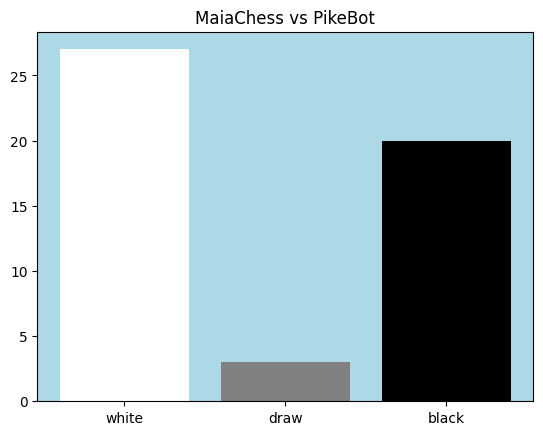

In [108]:
results = compare_engines(maiaChess, pikeBot, boards)
plot_results(results, 'MaiaChess', 'PikeBot')

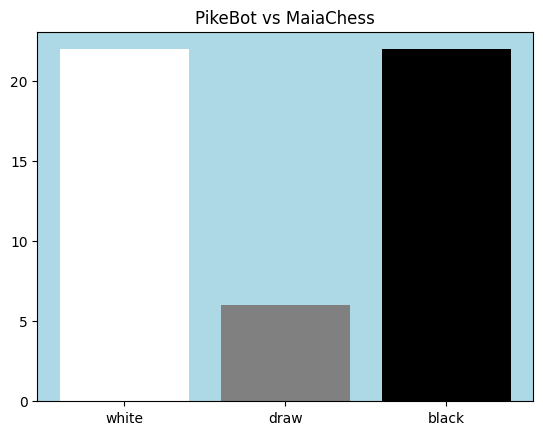

In [109]:
results = compare_engines(pikeBot, maiaChess, boards)
plot_results(results, 'PikeBot', 'MaiaChess')